In [6]:
# Importing required libraries
import numpy as np
import pandas as pd, datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn import preprocessing
get_ipython().run_line_magic('matplotlib', 'inline')
from time import time
import os
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame
import xgboost as xgb
#from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')


In [7]:
# Importing store data
path = r"D:\104 GB\10 Academy\Week-3\data\rossmann-store-sales\store.csv"
store = pd.read_csv(path)
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [18]:
# Importing train data
path_2 = r"D:\104 GB\10 Academy\Week-3\data\rossmann-store-sales\train.csv"
train = pd.read_csv(path_2, parse_dates = True)
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [19]:
# Importing test data
path_3 = r"D:\104 GB\10 Academy\Week-3\data\rossmann-store-sales\test.csv"
test = pd.read_csv(path_3, parse_dates = True)
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [20]:
train.shape, test.shape, store.shape

((1017209, 9), (41088, 8), (1115, 10))

In [21]:
train.isnull().sum().sum(), test.isnull().sum().sum()

(np.int64(0), np.int64(11))

In [22]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [23]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [24]:
#Check for when training and testing  data starts and when it ends 

print("Training data starts from: {}".format(train.Date.min()))
print("Training data end on: {}".format(train.Date.max()))
print("Testing data starts from: {}".format(test.Date.min()))
print("Testing data end on: {}".format(test.Date.max()))

Training data starts from: 2013-01-01
Training data end on: 2015-07-31
Testing data starts from: 2015-08-01
Testing data end on: 2015-09-17


In [25]:
#check 
train.Store.nunique() == store.Store.nunique()

True

In [26]:
#Join store and train data 
df_combined = train.merge(store, how='left', left_on=train.Store, right_on=store.Store)
df_combined.drop(['key_0', 'Store_y'], axis=1, inplace=True)
df_combined = df_combined.rename(columns={'Store_x':'Store'})
df_combined.shape

(1017209, 18)

In [27]:
#Statistical summary
round(df_combined.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
Store,1017209.0,558.43,321.91,1.0,280.0,558.0,838.0,1115.0
DayOfWeek,1017209.0,4.00,2.00,1.0,2.0,4.0,6.0,7.0
Sales,1017209.0,5773.82,3849.93,0.0,3727.0,5744.0,7856.0,41551.0
Customers,1017209.0,633.15,464.41,0.0,405.0,609.0,837.0,7388.0
Open,1017209.0,0.83,0.38,0.0,1.0,1.0,1.0,1.0
Promo,1017209.0,0.38,0.49,0.0,0.0,0.0,1.0,1.0
SchoolHoliday,1017209.0,0.18,0.38,0.0,0.0,0.0,0.0,1.0
CompetitionDistance,1014567.0,5430.09,7715.32,20.0,710.0,2330.0,6890.0,75860.0
CompetitionOpenSinceMonth,693861.0,7.22,3.21,1.0,4.0,8.0,10.0,12.0
CompetitionOpenSinceYear,693861.0,2008.69,5.99,1900.0,2006.0,2010.0,2013.0,2015.0


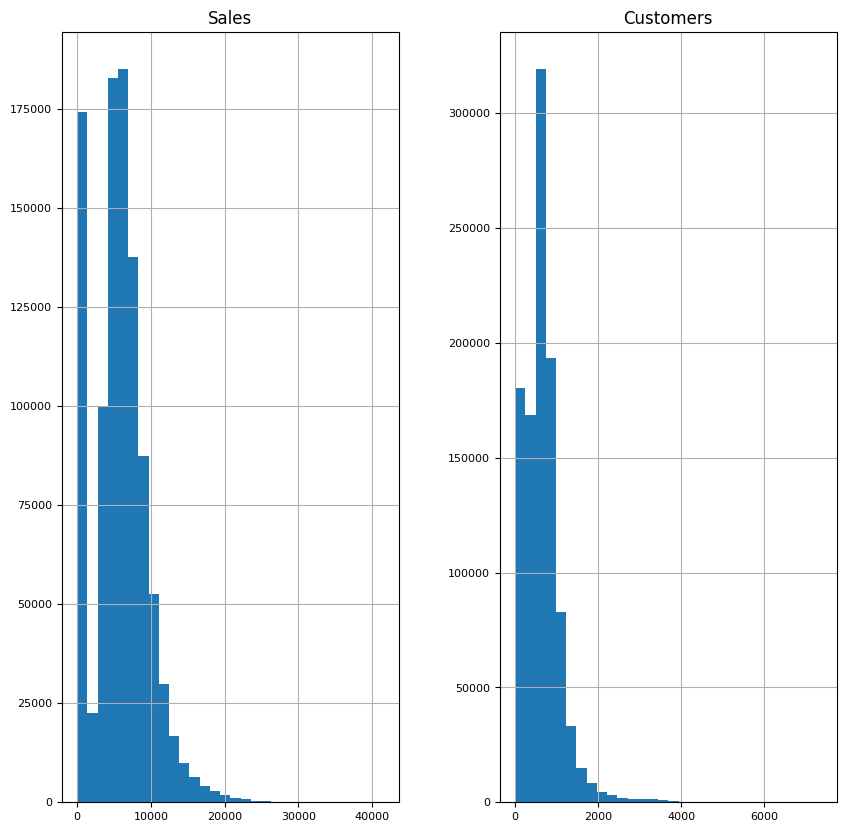

In [28]:
#plot the numeric data getting a quick look at the distributions.

df = train[['Sales', 'Customers']]
df.hist(figsize=(10, 10), bins=30, xlabelsize=8, ylabelsize=8);

In [29]:
df_combined.Date = pd.to_datetime(df_combined.Date)
df_combined['Day'] = df_combined.Date.dt.day
df_combined['Month'] = df_combined.Date.dt.month
df_combined['Year'] = df_combined.Date.dt.year
df_combined

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Day,Month,Year
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,1270.0,9.0,2008.0,0,NaN,NaN,NaN,31,7,2015
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",31,7,2015
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",31,7,2015
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,620.0,9.0,2009.0,0,NaN,NaN,NaN,31,7,2015
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,29910.0,4.0,2015.0,0,NaN,NaN,NaN,31,7,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,...,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",1,1,2013
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,...,1880.0,4.0,2006.0,0,NaN,NaN,NaN,1,1,2013
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,...,9260.0,NaN,NaN,0,NaN,NaN,NaN,1,1,2013
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,...,870.0,NaN,NaN,0,NaN,NaN,NaN,1,1,2013


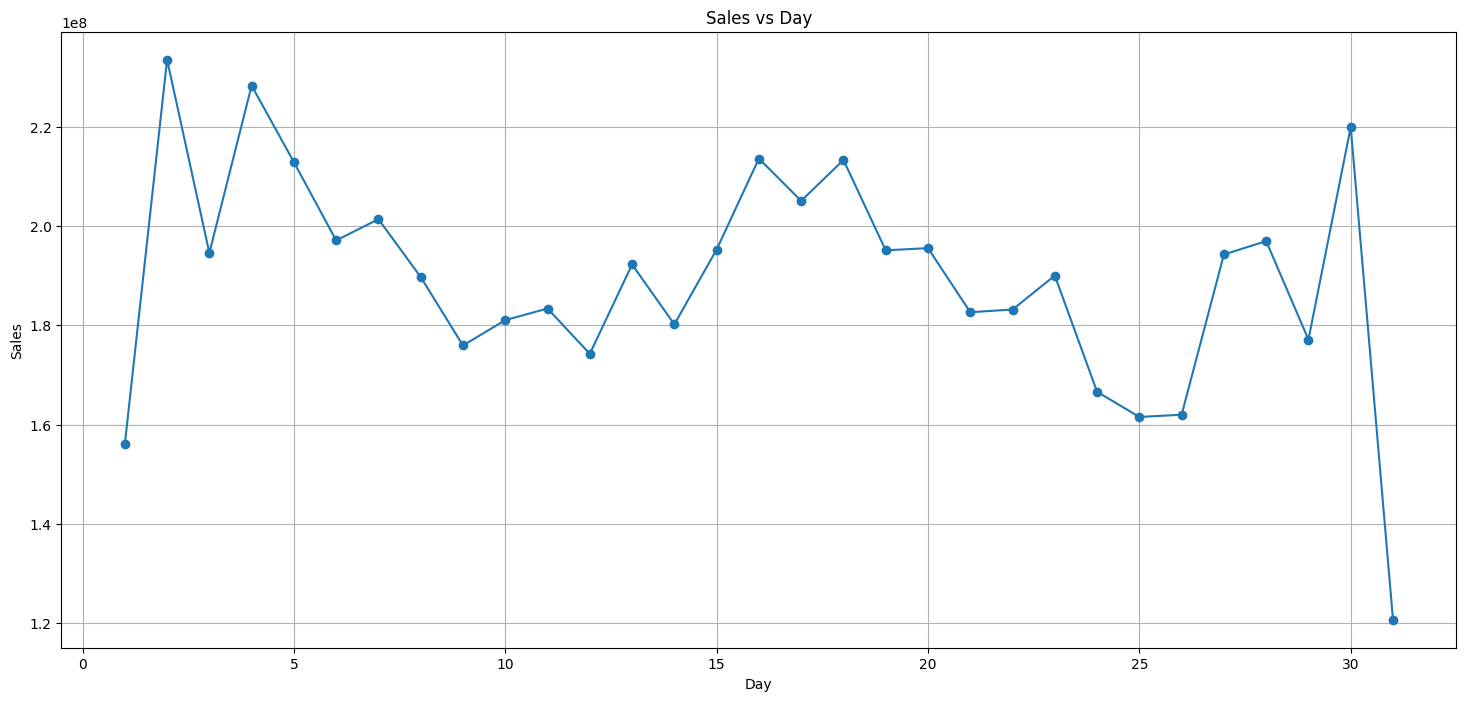

In [31]:
# Make a plot of Sales vs Day
plt.figure(figsize=(18, 8))
sales_by_day = df_combined.groupby("Day")["Sales"].sum()
plt.plot(sales_by_day, marker='o')
plt.title("Sales vs Day")
plt.xlabel("Day")
plt.ylabel("Sales")
plt.grid(True)
plt.show()

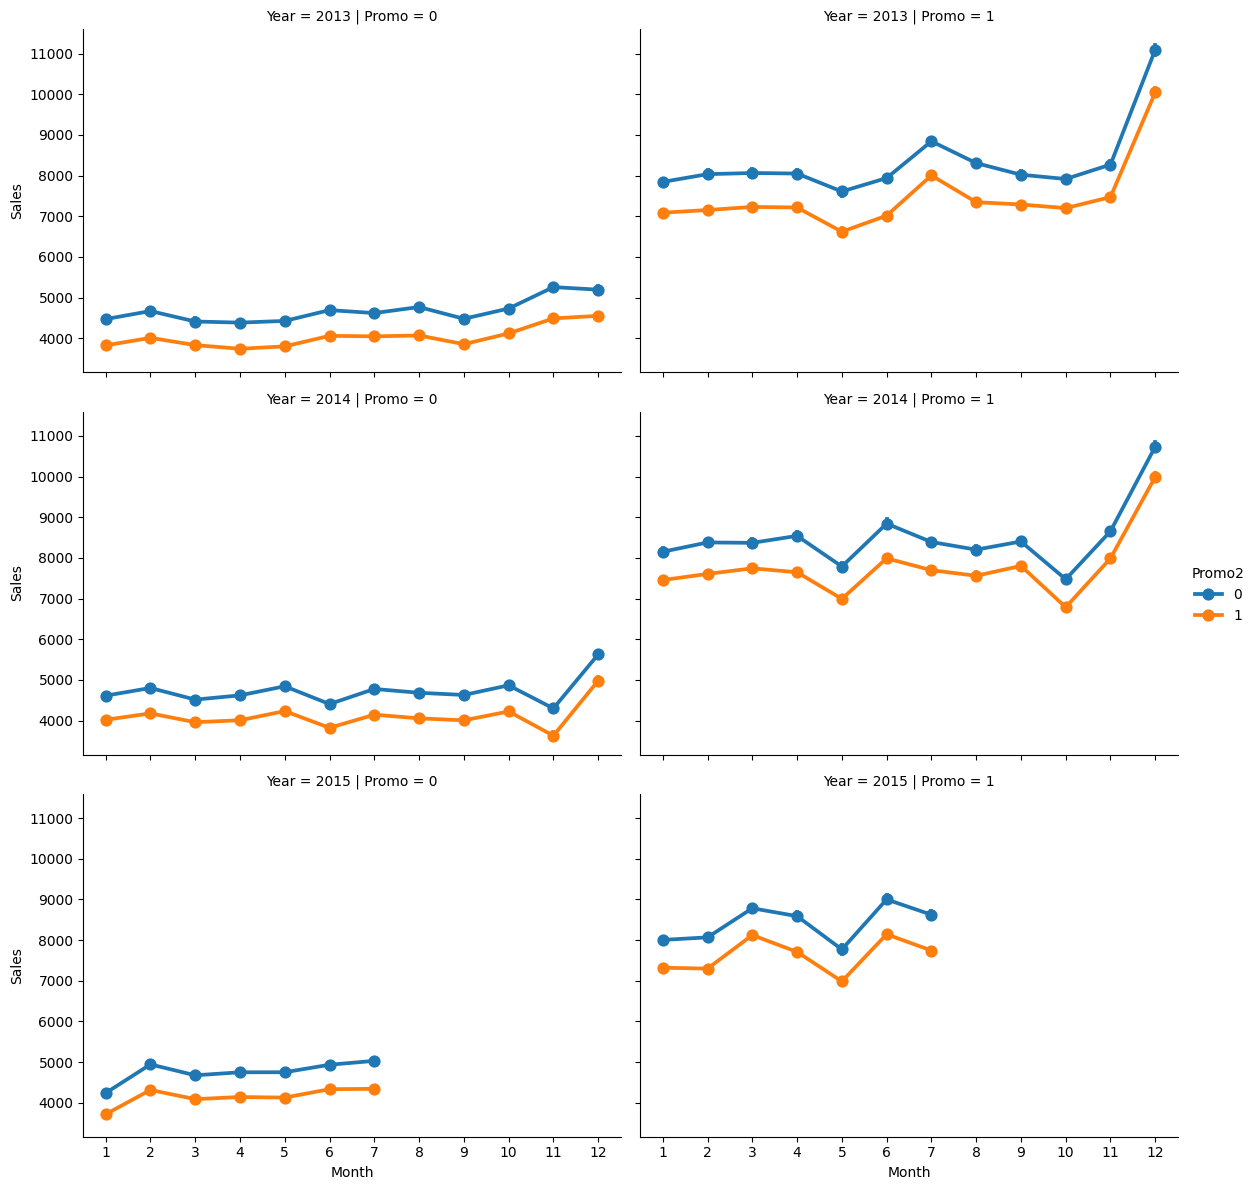

In [33]:
# Sales trend over the months and year
sns.catplot(
    data=df_combined,
    x="Month",
    y="Sales",
    col="Promo",
    hue="Promo2",
    row="Year",
    kind="point",
    height=4,
    aspect=1.5
)

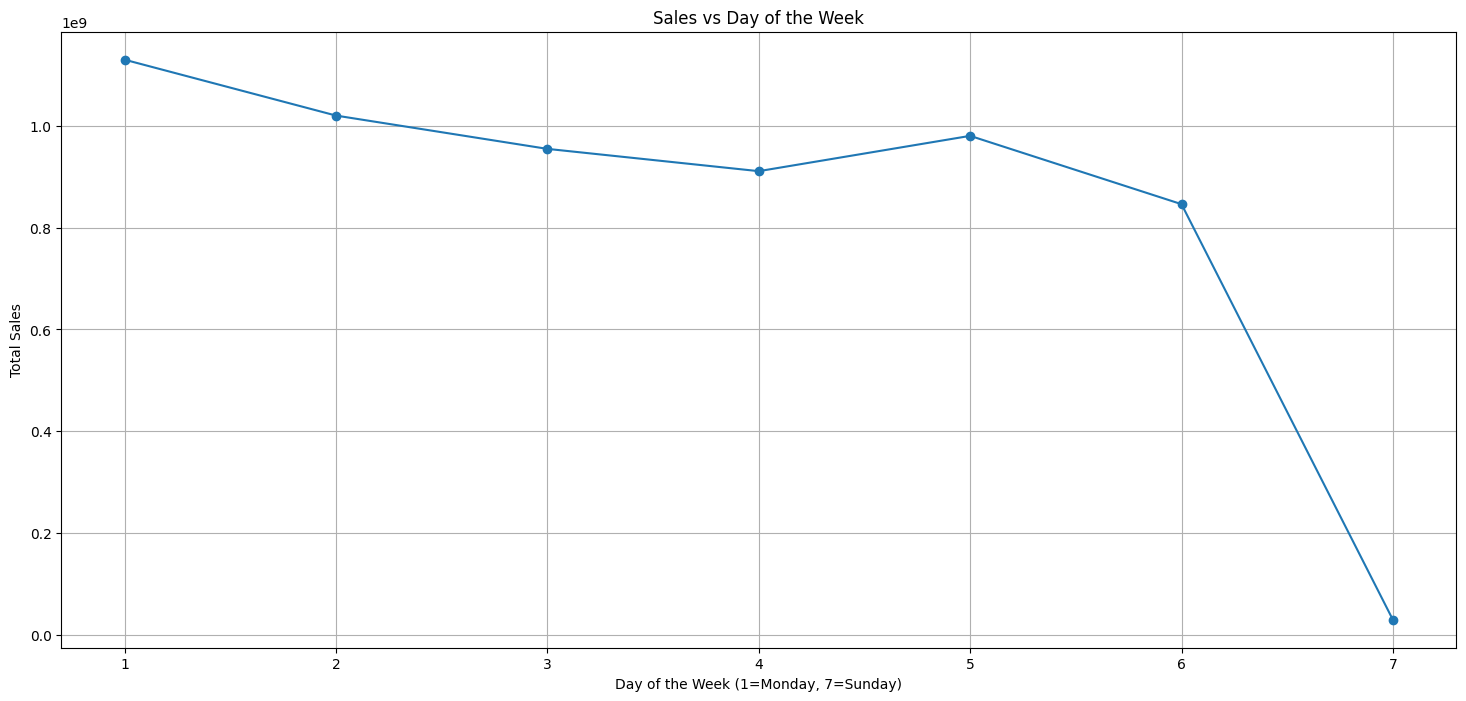

In [35]:
# Let us check for sales vs weeks
plt.figure(figsize=(18, 8))
sales_by_week = df_combined.groupby("DayOfWeek")["Sales"].sum()
plt.plot(sales_by_week.index, sales_by_week.values, marker='o')
plt.title("Sales vs Day of the Week")
plt.xlabel("Day of the Week (1=Monday, 7=Sunday)")
plt.ylabel("Total Sales")
plt.grid(True)
plt.show()

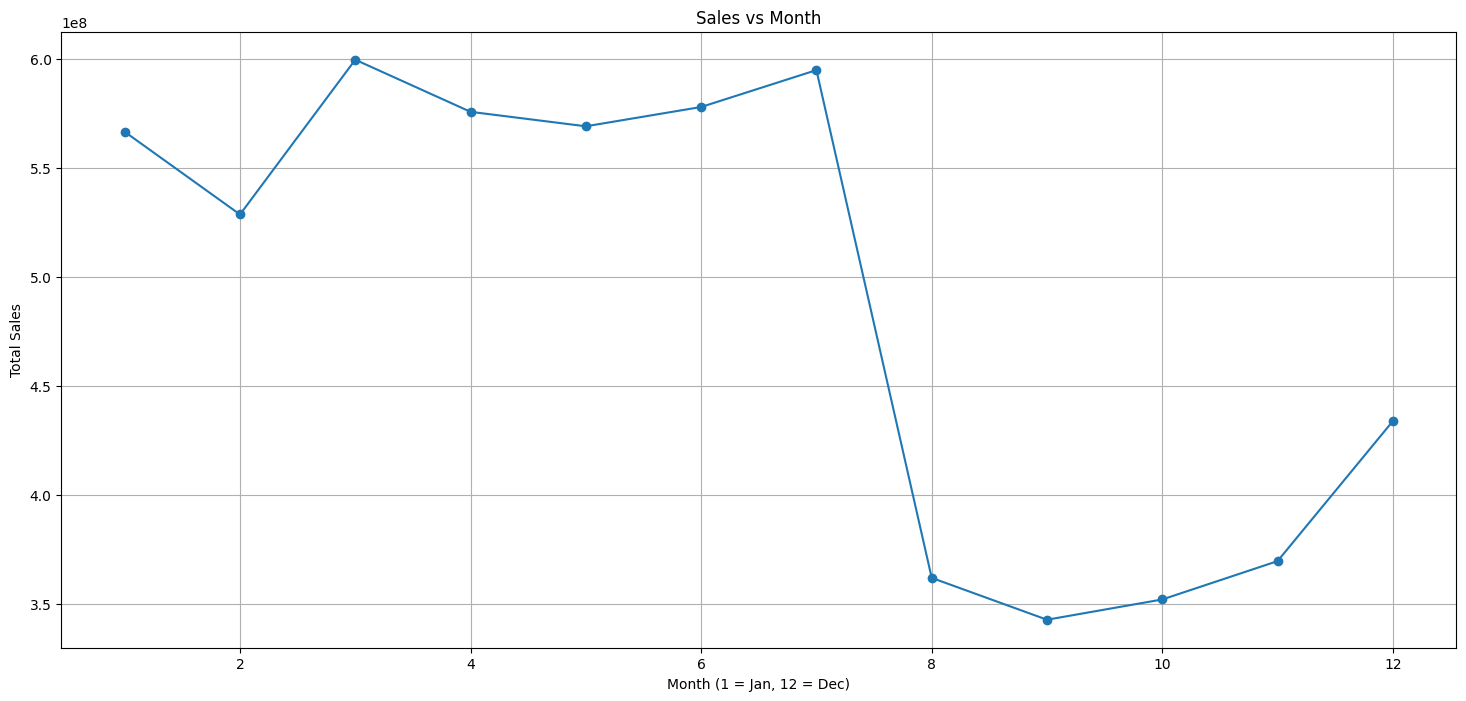

In [37]:
# Check for sales vs months
plt.figure(figsize=(18, 8))
sales_by_month = df_combined.groupby("Month")["Sales"].sum()
plt.plot(sales_by_month.index, sales_by_month.values, marker='o')
plt.title("Sales vs Month")
plt.xlabel("Month (1 = Jan, 12 = Dec)")
plt.ylabel("Total Sales")
plt.grid(True)
plt.show()

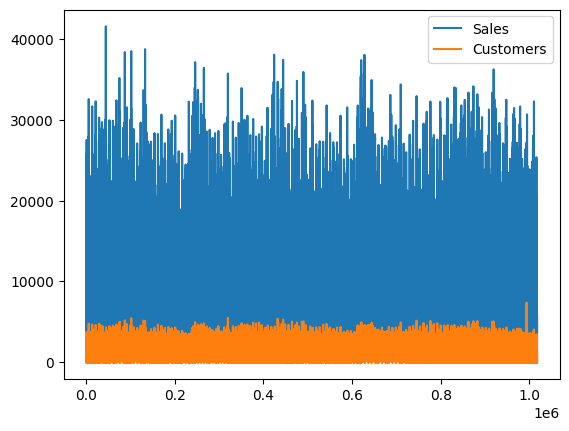

In [38]:

#check for seasonality 
train['Date'] = pd.to_datetime(train['Date']).dt.date
train_modified =train[['Date','Sales','Customers']]
train_modified.plot()
pyplot.show()

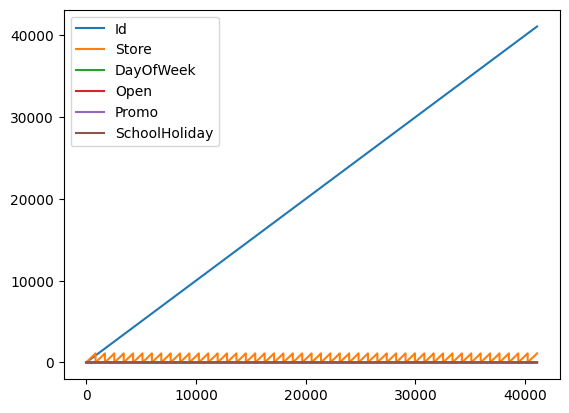

In [39]:

#Check for seasonality in the test data 
test['Date'] = pd.to_datetime(test['Date']).dt.date
test.plot()
pyplot.show()

In [45]:
train['StateHoliday'].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [40]:
#checking for correlation 
train.corr(method ='pearson')

ValueError: could not convert string to float: 'a'

In [ ]:
#checking for how prom afftects sales 
sns.barplot(x = train['Promo'], y = train['Sales'])
plt.show()

In [ ]:

sns.barplot(x = train['Promo'], y = train['Customers'])
plt.show()

In [ ]:
# Sales trend over days
sns.factorplot(data = train_store_joined, x = "DayOfWeek", y = "Sales", hue = "Promo")

In [ ]:
plt.figure(figsize=(10,6))
sns.set(style="whitegrid")
sns.violinplot(x='DayOfWeek',y='Sales',hue='Promo',split=True,data=df_combined)

In [ ]:

plt.figure(figsize=(10,6))
sns.set(style="whitegrid")
sns.violinplot(x='DayOfWeek',y='Customers',hue='Promo',split=True,data=df_combined)

In [ ]:
plt.figure(figsize=(12,6))
sns.set(style="whitegrid")
sns.lmplot(x='CompetitionDistance',y='Sales',data=df_combined)

In [ ]:
fig = plt.figure(figsize=(6, 6))
plt.scatter(df_combined['Sales'],df_combined['Customers'] ,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200)
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
sns.set(style="whitegrid")
sns.violinplot(x='Month',y='Customers',hue='Open',split=True,data=df_combined)

In [ ]:
Open_stores_weekdays = df_combined[(df_combined['DayOfWeek'] <6  ) & (df_combined['Open'] ==1)]
Open_stores_weekdays.Store.unique()

In [ ]:
df_combined['Assortment']

In [ ]:
assortment_encoder = preprocessing.LabelEncoder()
df_combined['Assortment'] = assortment_encoder.fit_transform(df_combined['Assortment'])

In [ ]:

df_combined['Assortment'].value_counts()

In [ ]:
sns.barplot(x = df_combined['Assortment'], y = df_combined['Sales'])
plt.show()

In [ ]:

stores_withNull =df_combined

In [ ]:
#df_combined_melted = df_combined.melt("Year",var_name="Store&CompetitionDistance",value_name="Rating")
sns.relplot(data=df_combined, x="Month", y="Store", hue="CompetitionDistance",kind="line", height=4, aspect=.7)